# Projekt wykonany przez: Kacper Kwaśnioch, Kacper Glazer 
# Grupa 17
## Dane 
Wykorzystane dane są z kaggle: https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us?select=PoliceKillingsUS.csv 

Dane składają się z informacji na temat osób zabitych przez policję w USA w ramach interwencji policyjnej. Całość składa się z 5 datasetów, w których możemy zaobserwować dane na temat wskaźniku ubóstwa, ukończenia szkoły średniej, mediany dochodu gospodarstw domowych, demografii rasowej oraz płciowej. Główny dataset skała się na dane osobowe osób zastrzelonych przez policję, imię, data śmierci, typ broni, czym i czy w ogóle była uzbrojona, wiek, rasa,miejsce zamieszkania. Dane zostały zbierane od 1 styczna 2015r. przez Washington Post, gazeta pozyskiwała dane ze stron internetowych organów ścigania, lokalnych raportów, mediów społecznościowych oraz poprzez monitorowanie niezależnych baz danych.

Jako zmienną **Y** obraliśmy **rase**, z której stworzyliśmy zmienną binarną wykorzystywana w modelach (pokrzywdzony był biały -1, jeżeli nie jest biały -0)

Za zmienne **X** posłużyły nam: age, date, signs_of_mental_illness, Median Income,poverty_rate, percent_completed_hs, share_white, share_black, share_native_american, share_asian, share_hispanic, threat_level, threat_level, gender
# Cel 

Wykorzystanie podejść:

*   Propensity score weighting
*   Propensity score matching
*   Mass imputation





In [6]:
!pip install catboost

     |████████████████████████████████| 69.2MB 67kB/s 


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import math
from statistics import variance
import warnings
warnings.filterwarnings('ignore')

In [42]:
df=pd.read_csv('https://raw.githubusercontent.com/whyme36/BI_2021/master/Fatal_Police_Shootings_in_the_US.csv')
preprocessing(df)

,date,age,race,signs_of_mental_illness,Median Income,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,attack,other,threat_level_undetermined,shot,M
0,1.420157e+09,53.0,0,1,37072.0,28.6,80.1,78.9,0.8,3.7,1.1,19.2,1,0,0,1,1
1,1.420157e+09,47.0,1,0,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1,1,0,0,1,1
2,1.443744e+09,55.0,1,1,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1,0,1,0,1,0
3,1.420243e+09,23.0,0,0,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3,0,1,0,0,1
4,1.440202e+09,26.0,1,0,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,1.500768e+09,49.0,1,0,45750.0,16.9,80.6,95.1,0.8,0.3,0.8,4.3,1,0,0,1,1
2051,1.500941e+09,16.0,0,0,61669.0,10.9,89.3,68.1,28.0,0.4,1.5,2.0,0,0,1,1,1
2052,1.501114e+09,39.0,0,0,27050.0,40.0,79.0,33.0,64.3,0.1,0.8,1.4,1,0,0,1,1
2053,1.501114e+09,34.0,0,0,34559.0,32.1,68.3,61.6,12.6,2.0,2.1,37.8,1,0,0,1,1


## Przetworzenie dancyh (Kwaśnioch):

*   wyrzucenie niepotrzebnych kolumn
*   wyrzucenie wierszy bez określonej rasy
*   przetworzenie zmiennych jakościowych 
*   wypełnienie pustych komórek średnimi ilościowymi (np. age)
*   przekonwertowanie zmiennej date w liczbę 
*   zmianna zmiennej ,,race" na zmienną binarną (1-White,0-None White)

Po przetworzeniu nasze dane mają formaty liczbowe



In [10]:
def preprocessing(df):
    df = df.drop(['id', 'name', 'city', 'state','body_camera', 'flee','armed'], axis=1)

    l_ch = []
    for e in df['threat_level']:
        if e == 'undetermined':
            l_ch.append('threat_level_undetermined')
        else:
            l_ch.append(e)
    df['threat_level'] = l_ch

    df = df[df['race'].notna()]
    df = df.reset_index(drop=True)

    df['age'] = df['age'].fillna(df['age'].median())
    df['Median Income'] = df['Median Income'].fillna(df['Median Income'].median())
    cols = [ 'threat_level', 'manner_of_death', 'gender'] #'armed'
    for col in cols:
        dummy = pd.get_dummies(df[col])
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(col,axis=1)
    df['signs_of_mental_illness'] = df['signs_of_mental_illness'].astype(int)
    ll =[datetime.strptime(element, '%d/%m/%y') for element in df['date']]
    ll2 = [e.strftime('%Y-%m-%d %H:%M:%S.%f') for e in ll]
    ll3 =[datetime.fromisoformat(element).timestamp() for element in ll2]
    df['date'] = ll3
    l_race  = []
    for e in df['race']:
        if e == 'W':
            l_race.append(1)
        else:
            l_race.append(0)
    df['race'] = l_race
    df = df.drop(['F', 'shot and Tasered'], axis=1)
    return df



## Korelacja (Glazer)

Sprawdzenie czy zienne ze sobą korelują, znależliśmy i wyrzuciliśmy jedne z kolumn:


*   'F' i 'M"
*   'shot and Tasered' i 'shot'

reszte zmiennych uznaliśmy za potrzebne.



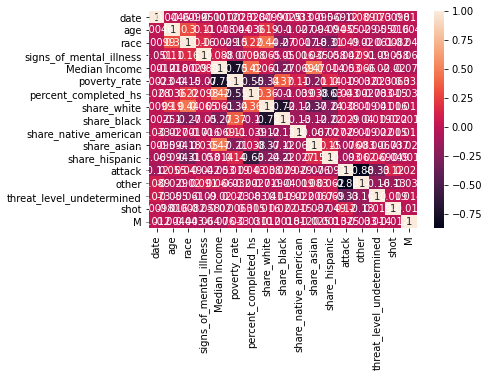

In [ ]:
corr_matrix=preprocessing(df).corr()
sn.heatmap(corr_matrix, annot=True)

## Utworzenie próby losowej i nielosowej (Kwaśnioch)
W naszym przypadku cała populacja liczy 2055 wierszy, z których tworzymy próby.

nielosowa - jest to zmieniający się zakres od [0:400] do  [100:500] elemtów (400 wystąpień w każdej próbie)

losowa- powstaje w wyniku próby warstwowej, za pośrednictwem zmiennej `state` (również 400 wystąpień)



In [11]:
def losowa_nielosowa_split(df,i, losowa_wielkosc = 400, if_sample = False):
  #tworzenie próby nielosowej sposób 1
  if if_sample == False:
    df_nielosowa = df[0+i:losowa_wielkosc+i]
    df_nielosowa = df_nielosowa.reset_index(drop=True)
  #Sprawdzanie ile wartosci znajduje się w populacji i ile chcemy przypisać do zbioru losowego
  import math
  dict_len = {}
  for e in df['state'].unique():
    lenn = math.ceil(len(df[df['state'] == e])/len(df)*losowa_wielkosc)
    dict_len[e] = lenn
  #obliczanie probability
  dict_prob = {}
  for e in dict_len.keys():
    prob = dict_len[e]/len(df[df['state'] == e])
    dict_prob[e] = prob
  #obliczanie wag
  dict_waga ={}
  for e in dict_prob.keys():
    waga = 1/dict_prob[e]
    dict_waga[e] = waga
  #tworzenie proby losowej
  proba_losowa = pd.DataFrame()
  for element in dict_len.keys():
    t = df[df['state'] == element].sample(n=int(dict_len[element]), replace=False, random_state = i)
    proba_losowa = pd.concat([proba_losowa, t])
  #dodawanie wag do proby losowej
  ll_wagi = []
  for e in proba_losowa['state']:
    waga = dict_waga[e]
    ll_wagi.append(waga)
  proba_losowa['waga'] = ll_wagi
  #tworzenie próby nielosowej sposób 2
  if if_sample == True:
    df_dla_nielosowa = df[~df.index.isin(proba_losowa.index)]
    df_nielosowa = df_dla_nielosowa.sample(n = losowa_wielkosc, random_state=i)
    df_nielosowa = df_nielosowa.reset_index(drop=True)

  return proba_losowa, df_nielosowa

## Funkcja weightedMean oblicza średnią ważoną oraz funkcja BiasVarMSE obliczająca obciążenie/Wariancje/MSE (Glazer)

In [12]:
def weightedMean(Y,W,n) :
      """
    :param Y - zmienna celu: 
    :param W - wagi : 
    :param n - wielkość zbioru: 
    :return: 
    """
    sum = 0
    numWeight = 0
    i = 0
    while  i < n :     
        numWeight = numWeight + Y[i] * W[i]
        sum = sum + W[i]
        i = i + 1
    return round((numWeight / sum),4)

In [38]:
df_population_mean=preprocessing(df)['race'].mean()

def BiasVarMSE(Srednie_wazone_modelu,Wariancja_array,nazwa_podejscia):
  """
    :param Srednie_wazone_modelu - tablica z średnimi wyliczonymi w pętli (100 średnich): 
    :param Wariancja_array - tablica variancji próby nielosowej dla zmiennej celu y-,,race": 
    :param nazwa_podejscia - etykieta metody: 
    :return: 
    """
  bias=round(np.array(Srednie_wazone_modelu).mean()-df_population_mean,4)
  var = round(np.array(Wariancja_array).mean(),4)
  MSE=round(bias**2+var,4)
  return nazwa_podejscia,bias,var,MSE

## Symulacja

Każde z podejść estymowaliśmy 100, zapisując wyniki do tablic.

Podejście **propensity score weighting** zostało zastosowane do modelu **RandomForestClassifier**..

Podejście **propensity score matching** zostało zastosowane do modelu  **CatBoostClassifier**.

Podejście **mass imputation** zostało zastosowane do modelu  **CatBoostClassifier**.

Został również wyliczony model **naiwny**.

Naiwny (Glazer)

In [ ]:
Srednie_wazone_naiwny=[]
Variance_naiwny=[]
for i in range(100):
  #tworzenie prób
  df_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
  #oczyszczenie prób
  df_nielosowa=preprocessing(df_nielosowa)
  df_losowa=preprocessing(df_losowa)
  #Wyliczenie średniej i wariancji 
  naiwny = df_nielosowa['race'].mean()
  var = variance(df_nielosowa['race'])
  Variance_naiwny.append(var)
  Srednie_wazone_naiwny.append(naiwny)
  # postęp pracy
  print(f'{i+1} z 100 został ukończony!')

Propensity score weighting (Glazer)

In [ ]:
Srednie_wazone_PSW=[]
Variance_PSW=[]
for i in range(100):
    i = i+100
    #tworzymy próby losowe i nielosowe
    df_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
    df_nielosowa=preprocessing(df_nielosowa)
    df_nielosowa['R']=1

    # wyrzucamy z losowej Y 
    df_losowa=preprocessing(df_losowa)
    df_losowa_X=df_losowa.drop('race', axis=1)
    df_losowa_X['R']=0

    # tworzymy model z połączenia prób
    df_to_model = pd.concat([df_losowa_X, df_nielosowa])
    y = df_to_model['R']
    X = df_to_model.drop(['R', 'race', 'waga'], axis=1)
    model_rf = RandomForestClassifier(max_depth=1, random_state=2,verbose=False)
    model_rf.fit(X, y)
    
    #Propensity score weighting
    
    y_prob_rf = model_rf.predict_proba(X)
    #otzymaliśmy prawdopodobieństwa array([0.57078367, 0.42921633]) wiemy iz [prawdopodobieństwo_nie_bycia_bialym, prawdopodobieństwo_bycia_bialym]. Dodajemy więc prawdobodobienstwo bycia białym 
    df_to_model['prob']=[x[1] for x in y_prob_rf]
    # z danych wyjmujemy próbe nielosową
    df_nielosowa_PSW=df_to_model.loc[df_to_model['R']==1]
    #tworzymy wagi 1/prawdopodobieństwo
    df_nielosowa_PSW['waga']=round(1/df_nielosowa_PSW['prob'],2)

    #liczymy średnie i wariancje
    PSW=weightedMean(df_nielosowa_PSW['race'],df_nielosowa_PSW['waga'],len(df_nielosowa_PSW))
    Srednie_wazone_PSW.append(PSW)
    var = variance(df_nielosowa_PSW['race'])
    Variance_PSW.append(var)
    # postęp pracy
    print(f'{i+1} z 100 został ukończony!')
    
    

Propensity score matching (Kwaśnioch)

In [ ]:
Srednie_wazone_PSM=[]
Variance_PSM=[]
for i in range(100):
  i = i+200
#tworzymy próby losowe i nielosowe
  proba_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
  proba_losowa= preprocessing(proba_losowa)
  df_nielosowa= preprocessing(df_nielosowa)

  df_nielosowa['R']=1
  proba_losowa=proba_losowa.drop(['race'], axis=1)
  proba_losowa['R']=0

  df_to_model = pd.concat([proba_losowa, df_nielosowa])

  model_cat = CatBoostClassifier(max_depth=2, random_state=2,verbose=False)

  y = df_to_model['R']
  X = df_to_model.drop(['R','race', 'waga'], axis=1)

  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  model_cat.fit(X_train, y_train)

  y_prob_cat = model_cat.predict_proba(X)
  score = model_rf.score(X_test, y_test)
  print(score)

  prob_list = []
  for e in y_prob_cat:
    prob_list.append(e[1])
  prob_list=[round(e,2) for e in prob_list]

  df_to_model['prob'] = prob_list
  proba_losowa = df_to_model[df_to_model['race'].isna()]
  df_nielosowa = df_to_model[df_to_model['waga'].isna()]

    #tworze dwa dict jeden z prob z losowej jeden z nielosowej
  lis_min = []
  dist_los = proba_losowa['prob'].to_dict()
  dist_nlos = df_nielosowa['prob'].to_dict()

    #usupełniam matchujące do siebie prob z dwoch df, wynik dodaje do listy
  lis = []
  for index, row in proba_losowa.iterrows():
    for index_n, row_n in df_nielosowa.iterrows():
      if row['prob'] == row_n['prob']:
        lis.append((index, index_n))
    #Do kolejnej listy dodaję wagi znalezione w df_los
  lis2 = []
  for e in lis:
    indx = e[0]
    waga = proba_losowa[proba_losowa.index == indx]['waga'].tolist()
    waga = waga[0]
    lis2.append((waga,e[1]))

    #torze dict z kluczem jako index nielosowej, a value jako wagą matchującą
  lista_wag_n = {}
  for element in df_nielosowa.index:
    for tup in lis2:
      if element == tup[1]:
        lista_wag_n[element] = tup[0]
    #usuwam ze słownika początkowego znalezione wagi i indexy
  for e in lista_wag_n:
    dist_nlos.pop(e, None)

    # usupełniam brakujące elementy dobierając najbliższych sąsiadów z df_los
  ll_uzupelnienie = []
  for e in dist_nlos.keys():
    ll={}
    for e_l in dist_los.keys():
      val = abs(dist_nlos[e] - dist_los[e_l])
      ll[(e,e_l)]=val
    needed_val = min(ll.items(), key=lambda x: x[1])
    ll_uzupelnienie.append(needed_val[0])
    #sprawdzam jakie wagi miały dopasowane elementy z df_los
  ll_uzupelnienie_lis_2 = []
  for e in ll_uzupelnienie:
    indx = e[1]
    waga = proba_losowa[proba_losowa.index == indx]['waga'].tolist()
    waga = waga[0]
    ll_uzupelnienie_lis_2.append((waga,e[0]))
    #uzupełniam swój ostateczny dict dla nieloswej znalezionymi wagami
  for element in df_nielosowa.index:
    for tup in ll_uzupelnienie_lis_2:
      if element == tup[1]:
        lista_wag_n[element] = tup[0]

  df_nielosowa['waga'] = lista_wag_n.values()

  PSM=weightedMean(df_nielosowa['race'],df_nielosowa['waga'],len(df_nielosowa))
  Srednie_wazone_PSM.append(PSM)

  var = variance(df_nielosowa['race'])
  Variance_PSM.append(var)
  print(f'{i+1} z 100 został ukończony!')

Masowa imputacja (Kwaśnioch)

In [23]:
def imputacja_masowa(proba_losowa, df_nielosowa):
#podział zbiorów
  y = df_nielosowa['race']
  X = df_nielosowa.drop('race',axis=1)
  y_random = proba_losowa['race']
  X_random = proba_losowa.drop('race',axis=1)
#modelowanie
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  model = CatBoostClassifier(max_depth=8, random_state=2,verbose=False)
  model.fit(X_train, y_train)

#predykcja prawdopodobienstwa
  yhat = model.predict_proba(X)
  y_random = model.predict_proba(X_random)

  score = model.score(X_test, y_test)
  print(score)
#wybor prawdopodobienstwa, że 1 
  yhat_1 = []
  for e in yhat:
    yhat_1.append(e[1])
  y_random_1 = []
  for e in y_random:
    y_random_1.append(e[1])
#szukanie najbliższego sąsiada
  inserted_values = []
  for i in range(len(proba_losowa)):
    y_k = y_random_1[i]
    distances = np.abs(yhat_1 - y_k)
    min_index = distances.argmin()
    inserted_values.append(y.iloc[min_index])
#pobranie wag z proby losowej
  weights_array = proba_losowa['waga'].to_numpy()
  inserted_values = np.array(inserted_values)
#masowa imputacja, podejście 1 i 2
  mass_imputation_1 = np.multiply(weights_array, inserted_values).sum() / weights_array.sum()
  
  mass_imputation_2 = np.multiply(weights_array, y_random_1).sum() / weights_array.sum()
  var = variance(df_nielosowa['race'])
  Variance_MASS_1.append(var)
  return mass_imputation_1, mass_imputation_2

In [ ]:
Srednie_wazone_MASS_1=[]
Srednie_wazone_MASS_2=[]
Variance_MASS_1=[]

for i in range(100):
  i = i+300
  #tworzymy próby losowe i nielosowe
  proba_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
  proba_losowa= preprocessing(proba_losowa)
  df_nielosowa= preprocessing(df_nielosowa)

  #masowa imputacja
  mass_imputation_1, mass_imputation_2 = imputacja_masowa(proba_losowa, df_nielosowa)
  Srednie_wazone_MASS_1.append(mass_imputation_1)
  Srednie_wazone_MASS_2.append(mass_imputation_2)

  print(f'{i+1} z 100 został ukończony!')

## Wyliczenie średnich z tablic estymowanych wartości (Glazer)
Zauważalne jest, iż zarówno wszystkie estymacje są lepsze od naiwnej.
Najbliższa prawdziwej średniej jest Mass imputation nr 2. 

In [43]:
df_population_mean=preprocessing(df)['race'].mean()
print(f'Średnia naiwna: {round(np.array(Srednie_wazone_naiwny).mean(),4)}')
print(f'Średnia PSW: {round(np.array(Srednie_wazone_PSW).mean(),4)}')
print(f'Średnia PSM: {round(np.array(Srednie_wazone_PSM).mean(),4)}')
print(f'Średnia MASS 1 : {round(np.array(Srednie_wazone_MASS_1).mean(),4)}')
print(f'Średnia MASS 2 : {round(np.array(Srednie_wazone_MASS_2).mean(),4)}')
print(f'Średnia prawdziwa: {round(df_population_mean,4)}')


Średnia naiwna: 0.3896
Średnia PSW: 0.4225
Średnia PSM: 0.4045
Średnia MASS 1 : 0.4975
Średnia MASS 2 : 0.4781
Średnia prawdziwa: 0.4939


## BIAS/VAR/MSE (Glazer)

In [39]:
Wyniki = pd.DataFrame(np.array([BiasVarMSE(Srednie_wazone_PSW,Variance_PSW,'PSW'), 
                                BiasVarMSE(Srednie_wazone_PSM,Variance_PSM,'PSM'), 
                                BiasVarMSE(Srednie_wazone_naiwny,Variance_naiwny,'Naiwny'), 
                                BiasVarMSE(Srednie_wazone_MASS_1,Variance_MASS_1,'MASS1'),
                                BiasVarMSE(Srednie_wazone_MASS_2,Variance_MASS_1,'MASS2')]),
                   columns=['name','BIAS', 'VAR', 'MSE'])
Wyniki

,name,BIAS,VAR,MSE
0,PSW,-0.0714,0.2424,0.2475
1,PSM,-0.0894,0.2416,0.2496
2,Naiwny,-0.1043,0.2383,0.2492
3,MASS1,0.0036,0.2423,0.2423
4,MASS2,-0.0158,0.2423,0.2425




1.   Obciążenie jak i samo MSE jest największe dla estymatora PSM 
2.   Wariancje dla modeli MASS1 i MASS2 są takie same z uwagi na ten sam zakres danych brany do ich wyliczenia
3.   Najlepszy wynik MSE uzyskał model MASS1



